# Shapley values - prediction of lung cancer histological subtype with an aggregated radiomic model
In this jupyter notebook we provide a short example for the use of Shapley values to interpret aggregated radiomic models. We study the classification of the histological subtype of non-small cell lung cancer (NSCLC) from baseline 18F-FDG PET images. To do so, we use a radiomic model that aggregates features extracted from all the metastases of the patient.

In [1]:
%load_ext autoreload
%autoreload 2

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\radshap')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.base import clone

from radshap.shapley import Shapley
from radshap.plot import plot_bars, plot_pet

## 0. Load radiomic and clinical data

Our cohort gathers **109 NSCLC metastatic patients** with a baseline 18F-FDG PET scan (for the diagnosis of the metastatic disease) acquired before the beginning of their first line treatment. All their metastases were segmented by an experienced nuclear medicine physician. Here we study the binary classification task that consists of distinguishing the adenocarcinomas (i.e most common subtype of NSCLC) from the other subtypes (including squamous cell carcinomas).   

**Note:** We will need to adress the class imbalance to avoid ending up with a very low specificity.

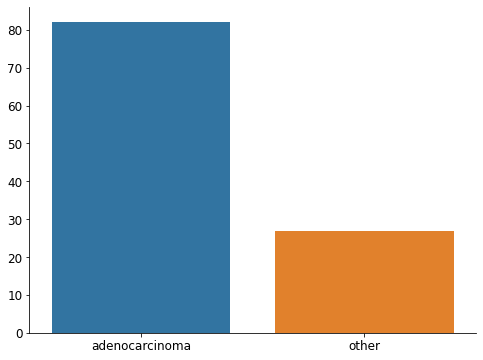

In [2]:
df_clinicals = pd.read_csv("..\\data\\clinicals.csv", index_col=0)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=df_clinicals["Histology"].value_counts().reset_index(), x="index", y="Histology", ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine()

We processed the segmented lesions with 3 steps:   

1. We applied an absolute threshold of 2.5 standardized uptake value (SUV) units, meaning that all voxel values less than 2.5 were excluded from the segmented tumor regions.
2. We filtered out very small lesions (< 1 mm3) as well as diffuse lesions whose precise segmentation and characterization by shape features is questionable (e.g diffuse pleural metastases, lymphangitic spreads...).
3. For all the remaining lesions we used pyradiomics to extract 4 shape radiomic features and 5 first-order radiomic features.

We first load the radiomic features of all the filtered lesions of every patients (each row corresponds to one lesion of one patient). In the following we will use this dataframe to aggregate features accross all the lesions and obtain one vector of features per patient.

In [3]:
df_radiomics_all = pd.read_csv("..\\data\\radfeatures_metastases.csv", sep=";", index_col=0)

# we log-transform the volume feature to avoid linear model to deal with highly right skewed distributions
df_radiomics_all.loc[:, "original_shape_VoxelVolume"] = df_radiomics_all["original_shape_VoxelVolume"].apply(lambda x: np.log(x+1))

df_radiomics_all.iloc[:, 3:].head()

,original_shape_Sphericity,original_shape_Elongation,original_shape_Flatness,original_shape_VoxelVolume,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_QuartileDispersion,original_firstorder_Skewness
patient_id,,,,,,,,,,
patient_0,0.829606,0.854212,0.623252,7.305860,2.851493,2.691843,5.045410,3.278775,0.142831,0.796080
patient_0,0.818499,0.944226,0.791394,7.110696,3.704616,2.848613,7.486134,4.159336,0.209644,0.765745
patient_0,0.848112,0.910863,0.672156,8.100768,4.044368,3.276046,9.588952,4.339738,0.279151,1.054416
patient_0,0.832378,0.716812,0.629970,8.852665,4.523944,3.097316,12.140698,5.072372,0.337011,1.019799
patient_0,0.767331,0.781909,0.650346,9.270965,4.456033,3.597569,11.830724,5.034145,0.262462,1.038186


We then load the radiomic features of the primary tumor of each patient. In the following we will use this dataframe to build a model only based on the radiomic characterization of the primary tumor and compare it to the aggregated radiomic model.

In [4]:
df_radiomics_primary = pd.read_csv("..\\data\\radfeatures_primitive.csv", index_col = 0)

# we log-transform the volume feature to avoid linear model to deal with highly right skewed distributions
df_radiomics_primary.loc[:, "original_shape_VoxelVolume"] = df_radiomics_primary["original_shape_VoxelVolume"].apply(lambda x: np.log(x+1))

df_radiomics_primary.iloc[:, 3:].head()

,original_shape_Sphericity,original_shape_Elongation,original_shape_Flatness,original_shape_VoxelVolume,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_QuartileDispersion,original_firstorder_Skewness
patient_id,,,,,,,,,,
patient_61,0.456610,0.749570,0.525133,2.610896,4.092132,8.024347,14.904233,4.417588,0.207731,1.909996
patient_51,0.818258,0.614170,0.478265,2.104640,2.786400,2.360157,4.624728,3.291910,0.131999,0.559409
patient_66,0.569751,0.889280,0.617822,2.457458,3.510267,2.572271,6.784972,3.862724,0.178942,0.549621
patient_72,0.786956,0.759483,0.687918,2.235043,4.492271,3.245385,12.379177,5.068335,0.351619,1.108584
patient_45,0.482746,0.699593,0.577001,2.573564,4.913414,4.555015,25.959015,5.869483,0.389705,1.200902


## 1. Aggregated model vs primary tumor model

Here we compare two simple logistic regression classifiers:
* A classifier which takes as input 10 radiomic features from the primary tumor - **primary tumor model**
* A classifier which takes as input the minimum and the maximum values of the same 10 radiomic features over all the metastases of the patient - **aggregated radiomic model**

### 1.1 Aggregate features with min and max

We apply min and max functions over all the lesions of every patients for each radiomic features. 

**Note:** We need to make sure that the features are properly ordered (i.e all the max features followed by all the min features). This reordering will greatly facilitate the application of our Shapley function to interpret the aggregated radiomic model.    
By default by pandas agg function orders columns like this | max_feature1 | min_feature1 | ... | max_feature10 | min_feature10 |, we rather want the columns to be ordered like | max_feature1 | max_feature2 | ... | min_feature9 | min_feature10 |

In [5]:
def reorder_columns(columns, function_names):
    d = {f_name: [] for f_name in function_names}
    for col in columns:
        d[col[1]].append(col)    
    return sum(d.values(), [])

In [6]:
df_agg = df_radiomics_all.iloc[:, 3:].groupby(level=0).agg(("max", "min")).loc[df_radiomics_primary.index]

#reorder columns
df_agg = df_agg[reorder_columns(df_agg.columns, function_names = ("max", "min"))]
df_agg.columns = df_agg.columns.map('_'.join)

df_agg.head()

,original_shape_Sphericity_max,original_shape_Elongation_max,original_shape_Flatness_max,original_shape_VoxelVolume_max,original_firstorder_Entropy_max,original_firstorder_Kurtosis_max,original_firstorder_Maximum_max,original_firstorder_Mean_max,original_firstorder_QuartileDispersion_max,original_firstorder_Skewness_max,original_shape_Sphericity_min,original_shape_Elongation_min,original_shape_Flatness_min,original_shape_VoxelVolume_min,original_firstorder_Entropy_min,original_firstorder_Kurtosis_min,original_firstorder_Maximum_min,original_firstorder_Mean_min,original_firstorder_QuartileDispersion_min,original_firstorder_Skewness_min
patient_id,,,,,,,,,,,,,,,,,,,,
patient_61,0.813979,0.749570,0.587445,12.611248,4.092132,8.024347,14.904233,4.417588,0.207731,1.909996,0.456610,0.717298,0.525133,7.427144,2.918195,2.267898,5.038346,3.407746,0.148505,0.392954
patient_51,0.818258,0.634642,0.514552,9.678905,4.744321,4.602220,15.611525,5.491285,0.314918,1.269447,0.806218,0.614170,0.478265,7.204149,2.786400,2.360157,4.624728,3.291910,0.131999,0.559409
patient_66,0.877978,0.967925,0.709036,10.675099,4.373615,2.909223,9.820923,5.062296,0.274770,0.870769,0.569751,0.356940,0.271548,6.947937,2.535151,2.104921,4.491053,3.097453,0.109580,0.269794
patient_72,0.851373,0.987156,0.812721,10.244841,4.773813,8.209222,16.108093,5.748157,0.351619,1.999782,0.543404,0.168818,0.122695,6.916715,2.518119,2.648929,4.420622,3.107107,0.094849,0.590309
patient_45,0.848916,0.912261,0.717279,12.112471,5.466307,5.510136,25.959015,8.333114,0.389705,1.668085,0.361679,0.343257,0.235947,7.316548,3.178103,2.023248,6.341872,3.463635,0.154060,0.326209


### 1.2 Train and test logistic regression models with repeated cross-validation schemes

We use a repeated stratified cross-validation scheme with 5 folds and 20 repeats to train and test our models. Several classification metrics are computed for each cross-validation scheme and averaged over the 20 repeats (balanced accuracy, ROC AUC, sensitivity, and specificity).

In [7]:
X_all = df_agg.values
X_primary = df_radiomics_primary.iloc[:, 3:].values
y = 1*(df_clinicals["Histology"] == 'adenocarcinoma').values

In [8]:
pipe = Pipeline(steps = [("scaling", StandardScaler()),
                         ("logistic", LogisticRegression(class_weight = "balanced"))
                        ]
               )

In [9]:
# define specificity scorer
def specificity_scorer(y_true, y_pred):
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    N = (1-y_true).sum()
    return TN/N

specificity = make_scorer(specificity_scorer)

cv_all = cross_validate(estimator=pipe, 
                        X=X_all,
                        y=y,
                        cv=RepeatedStratifiedKFold(n_repeats=20, n_splits=5),
                        scoring={'roc_auc': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'specificity': specificity, 'sensitivity': 'recall'})

cv_primary = cross_validate(estimator=pipe, 
                            X=X_primary,
                            y=y,
                            cv=RepeatedStratifiedKFold(n_repeats=20, n_splits=5),
                            scoring={'roc_auc': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'specificity': specificity, 'sensitivity': 'recall'})

### 1.3 Display the results

In [10]:
results_all = pd.DataFrame({'_'.join(key.split('_')[1:]): value for key, value in cv_all.items()}).iloc[:, 1:]
results_all['model'] = 'all'
results_primary = pd.DataFrame({'_'.join(key.split('_')[1:]): value for key, value in cv_primary.items()}).iloc[:, 1:]
results_primary['model'] = 'primary'
results = pd.concat([results_all, results_primary], axis=0)

results.groupby("model").mean()

,roc_auc,balanced_accuracy,specificity,sensitivity
model,,,,
all,0.761612,0.703455,0.644667,0.762243
primary,0.718450,0.657842,0.628000,0.687684


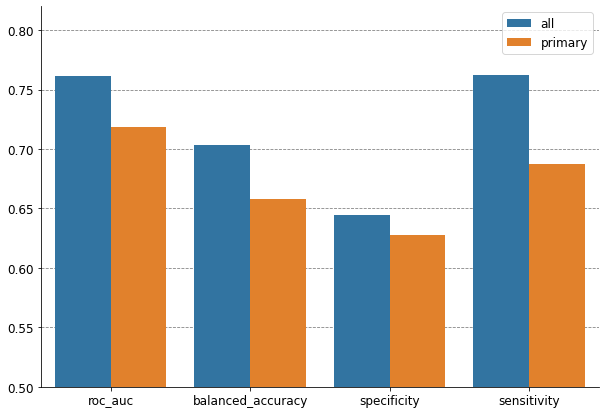

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data = results.melt(id_vars = ["model"]), x="variable", y="value", hue="model", errwidth=0)
ax.set_ylim(0.5, 0.82)
ax.set(xlabel=None, ylabel=None)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
sns.despine()

The aggregated radiomic model that takes into account all the metastases of the patient outperforms the model that only considers his primary lung tumor. In particular, it is more sensitive and detects better the adenocarcinomas. It is a promising result since the aggregation functions that we used were very simple and we can thus hope for more striking improvements with more complex aggregation strategies.

## 2. Interpretation of the aggregated model with Shapley values

Here we use the **radshap package** to interpret our aggregated radiomic model and highlight the importance of each lesion for the prediction of the histological subtype. In particular we use the **radshap package** to study which metastases the aggregated model uses (other than the primary tumor) to better predict the histological subtype of the patient

* We first re-train both our aggregated radiomic and our primary model on the whole data set (i.e 109 patients).
* We use these trained models to predict the histological subtype of each patient. We then focus on those who were missclassified by the primary model and correctly classified by the aggregated model.
* For such patients we compute the Shapley values of each of their metastases to highlight their importance for the prediction made by the aggregated radiomic model.

### 2.1 Train and predict on the whole data set

In [12]:
model_all = clone(pipe).fit(X_all, y)
model_primary = clone(pipe).fit(X_primary, y)

In [13]:
df_probas = pd.DataFrame(np.hstack([model_all.predict_proba(X_all)[:, 1].reshape(-1, 1),
                                    model_primary.predict_proba(X_primary)[:, 1].reshape(-1, 1),
                                    y.reshape(-1, 1)]
                                  ),
                         index=df_agg.index,
                         columns = ["probas_all", "probas_primary", "labels"])

df_probas["probas_gap"] = np.abs(df_probas["probas_all"] - df_probas["probas_primary"])

mask = (model_all.predict(X_all) == y) & (model_primary.predict(X_primary) != y)

df_probas[mask].sort_values(by="probas_gap", ascending = False).iloc[:, :-1].head(10)

,probas_all,probas_primary,labels
patient_id,,,
patient_54,0.285541,0.790982,0.0
patient_10,0.921771,0.421308,1.0
patient_30,0.900894,0.451829,1.0
patient_34,0.867559,0.489715,1.0
patient_82,0.630211,0.259418,1.0
patient_83,0.746399,0.430062,1.0
patient_43,0.755253,0.463816,1.0
patient_75,0.724156,0.437398,1.0
patient_93,0.778793,0.493737,1.0


Overall 22 patients who were misclassified by the primary model were correctly classified by the aggregated radiomic model. The table above shows the predicted probabilities of the class 1 (i.e adenocarcinoma) for both models as well as the true label of each patient. The 22 patients are ordered by the gap in absolute value between the predicted probability of the primary model and the predicted probability of the aggregated model (from top to bottom). 

### 2.2 Classical feature importance analysis

We can first take advantage of the coefficients of the logistic regression to highlight the importance of each aggregated radiomic feature. A positive coefficient means that a high value of the associated feature increases the probability of adenocarcinoma while a negative coefficient means that a high value of the associated feature decreases the probability of adenocarcinoma.

**Note:** Since the features are standardized before training the logisitic regression, a "high value" should be understood as "a value greater than the average of this feature".

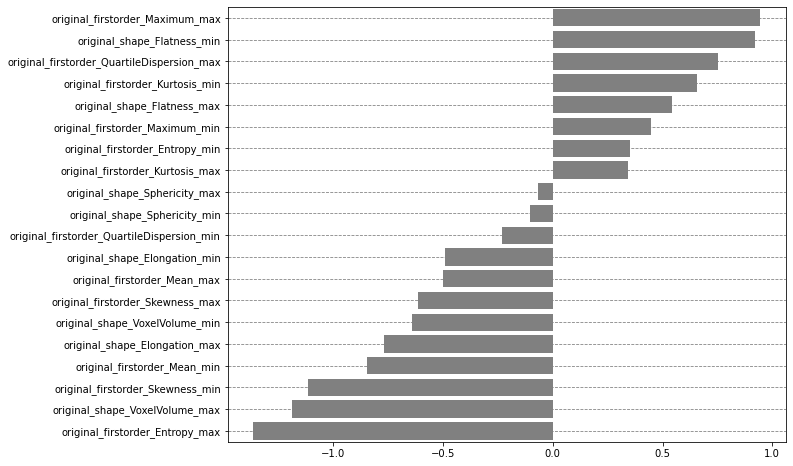

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = pd.DataFrame(model_all["logistic"].coef_.reshape(-1,1), index = df_agg.columns).sort_values(by=0, ascending=False).reset_index(),
            y="index",
            x=0,
            orient="h",
            ax=ax,
            color = "gray")
ax.set(xlabel=None, ylabel=None)
ax.set_axisbelow(True)
ax.yaxis.grid(color="gray", linestyle="dashed")

* The model learned that metastatic profiles with spherical metabolic volumes, high maximum intensities and heavy-tailed distributions of the FDG updtake intensity (i.e extreme/outlier values) were more likely to be associated with the adenocarcinoma subtype. 
* On the contrary, the model learned that metastatic profiles with large metabolic volumes, and at least one lesion with high entropy were more likely not to be associated with the adenocarcinoma subtype.

### 2.3 Compute and display Shapley values

Contrary to the analysis above, Shapley values computed by the **radshap package** allow us to study each patient specifically and highlight the importance of their metastases for the prediction of the model. Besides it can explain the decision of the model for new unseen patients.

In [15]:
shap = Shapley(predictor = lambda x: model_all.predict_proba(x)[:, 1], aggregation = [('max', None), ('min', None)])

####  Patient 54

In [16]:
# extract the radiomic features of all the lesions of the patient 54 
x_explain = df_radiomics_all.loc["patient_54"].iloc[:, 3:].copy().values

shap_values = shap.explain(x_explain)

We first use a bar plot to display the Shapley values. They are ranked from top to bottom in decreasing order with respect to their absolute value. A negative Shapley value means that considering the associated lesion for the prediction of the histological subtype with the aggregated model decreases the probability of the class 1 (i.e adenocarcinoma) while a positive Shapley value means that it increases the probability of the class 1.

For this patient with only two lesions it is quite simple to explicitly detail the formula of the Shapley value. It will help us better understand its meaning:

\begin{align*}
&\phi(\text{META_LUNG}) = \dfrac{1}{2} \left( pred(\{\text{META_LUNG, PRIMARY}\}) - pred(\{\text{PRIMARY}\}) \right) + \dfrac{1}{2} \left( pred(\{\text{META_LUNG}\}) - pred(\emptyset) \right)\\
&\phi(\text{META_LUNG}) = \dfrac{1}{2} \left(0.29 - 0.89 \right) + \dfrac{1}{2} \left(0.36  - 0.5 \right) = -0.37
\end{align*}

It averages the marginal contributions of the lesion when it is considered on its own and when it is added to the other lesion.

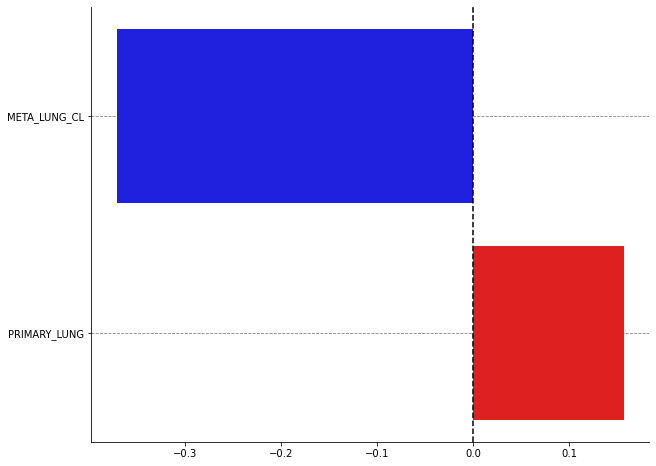

In [17]:
plot_bars(shap_values, names=["META_LUNG_CL", "PRIMARY_LUNG"], nbest=15)

We can also use the Maximum Intensity Projection (MIP) of the baseline PET image as well as a color scale to display the Shapley values. 

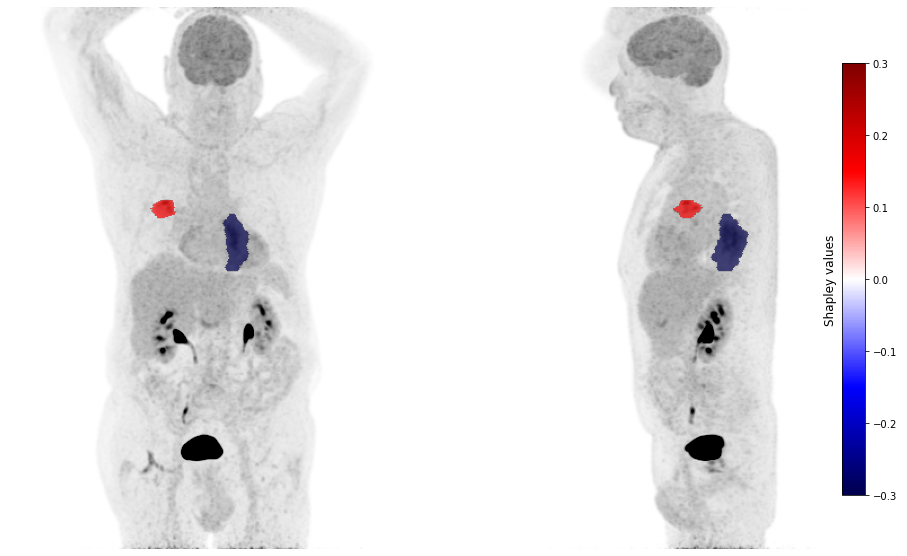

In [18]:
image_path = "D:\\Images\\patient_54\\baseline_PET\\PET.nii.gz"
mask_path = "D:\\Images\\patient_54\\baseline_PET\\segmentations\\"
mask_paths = []
for name in df_radiomics_all.loc["patient_54", "Unnamed: 2"].values:
    mask_paths.append(mask_path + name + '.uint16.nii.gz')
    
plot_pet(shap_values, image_path=image_path, masks_paths=mask_paths, cmap_lim = 0.3)

For the patient 54, the radiomic characteristics of the primary tumor bias the model towards the prediction of an adenocarcinoma. It is the presence of the controlateral lung metastasis (and its radiomic characteristics) that help the model to correctly predict another histological subtype than adenocarcinoma.

####  Patient 30

In [19]:
# extract the radiomic features of all the lesions of the patient 10 
x_explain = df_radiomics_all.loc["patient_30"].iloc[:, 3:].copy().values

shap_values = shap.explain(x_explain, n_jobs=-1)

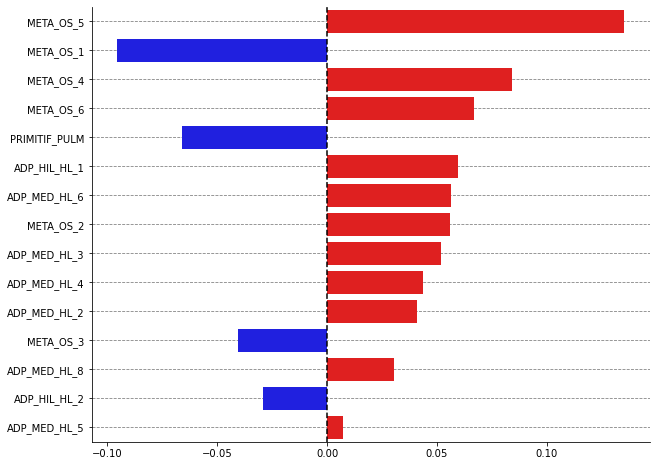

In [20]:
plot_bars(shap_values, names=df_radiomics_all.loc["patient_30", "Unnamed: 2"].values, nbest=15)

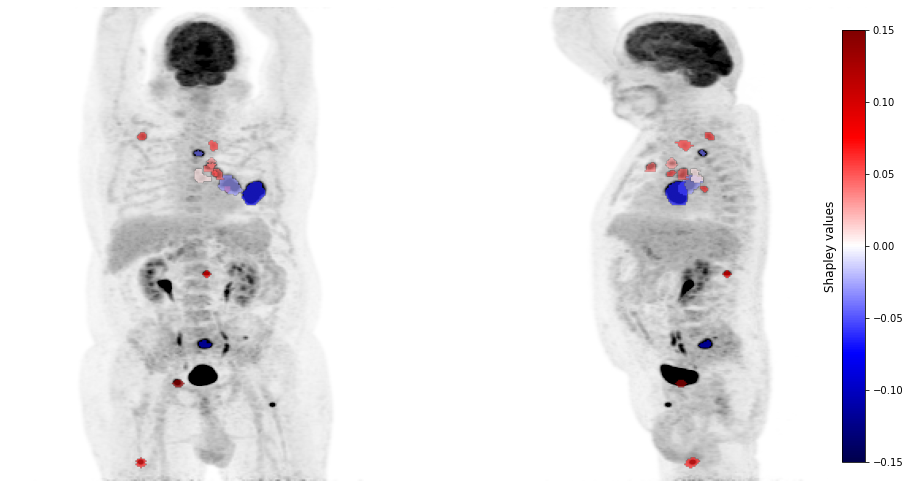

In [21]:
image_path = "D:\\Images\\patient_30\\baseline_PET\\PET.nii.gz"
mask_path = "D:\\Images\\patient_30\\baseline_PET\\segmentations\\"
mask_paths = []
for name in df_radiomics_all.loc["patient_30", "Unnamed: 2"].values:
    mask_paths.append(mask_path + name + '.uint16.nii.gz')
    
plot_pet(shap_values, image_path=image_path, masks_paths=mask_paths, cmap_lim = 0.15)

Though some lesions of the patient 30, including the primary tumor, bias the prediction of the aggregated model towards an other subtype than adenocarcinoma, a wide majority of the metastases (including distant bone metastases in the femur, the hip or the lumbar spine) drive the prediction of the aggregated radiomic model towards an adenocarcinoma subtype.